# Explainable AI

## Testing out Different Algorithms/Methods used in Explainable AI

### Imports

| Library | Purpose |
| ---: | ---: |
| warnings | Ignore warnings |
| torchvision | Access to pre-trained pytorch vision models |
| numpy | Array operations |
| cv2 | Image operations |
| pytorch_grad_cam | Access to GradCAM algorithms |
| requests | Access to web resources (downloading images) |
| PIL | Image operations |


In [13]:

def category_name_to_index(model, category_name):
  """ Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

  """
  name_to_index = dict((v, k) for k, v in model.config.id2label.items())
  return name_to_index[category_name]

In [14]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import run_dff_on_image, GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

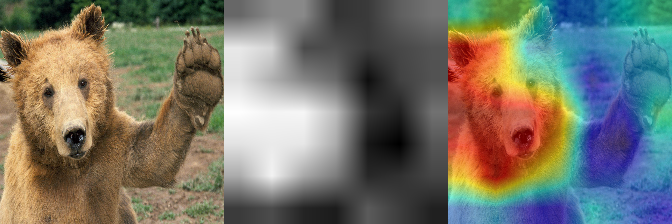

In [15]:

model = models.resnet50(pretrained=True)
model.eval()
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

In [16]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional
dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]
img_tensor = transforms.ToTensor()(image)

""" Model wrapper to return a tensor"""
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

""" Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

"""
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]
    
""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.
    
"""
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module=img_tensor,
                          input_image: Image=image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)
    
    
def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

No config specified, defaulting to: cats-image/image


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 515.46it/s]


Dataset cats-image downloaded and prepared to /Users/amittaijoel/.cache/huggingface/datasets/huggingface___cats-image/image/1.9.0/68fbc793fb10cd165e490867f5d61fa366086ea40c73e549a020103dcb4f597e. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 231.26it/s]


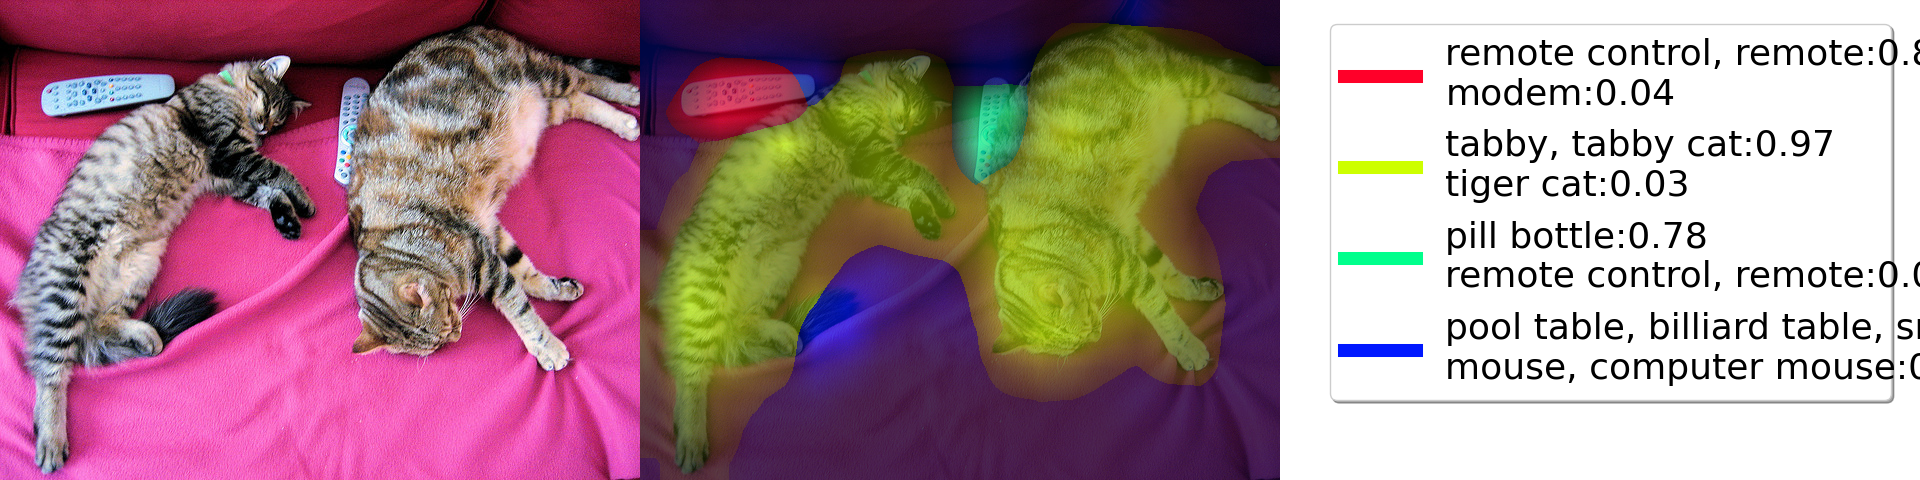

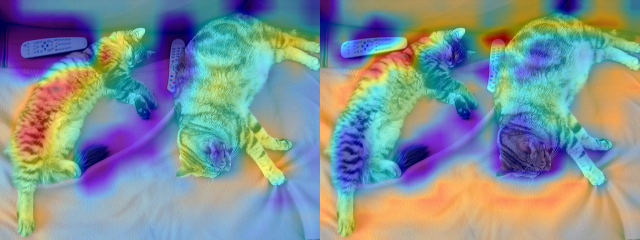

Now with ScoreCAM instead of GradCAM:


100%|██████████| 10/10 [01:39<00:00,  9.95s/it]


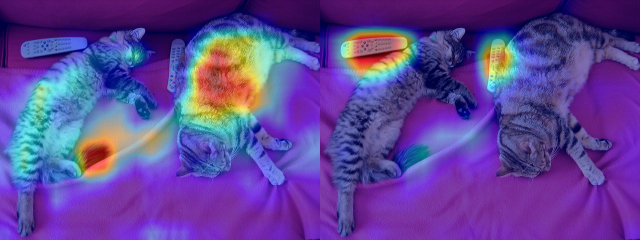

Predicted class 281: tabby, tabby cat
Predicted class 282: tiger cat
Predicted class 761: remote control, remote
Predicted class 285: Egyptian cat
Predicted class 673: mouse, computer mouse


In [17]:
from transformers import MobileViTForImageClassification
from pytorch_grad_cam import ScoreCAM
model = MobileViTForImageClassification.from_pretrained("apple/mobilevit-small")
target_layer = model.mobilevit.conv_1x1_exp
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote control, remote"))]

display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=model.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=None,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=None)))
print('Now with ScoreCAM instead of GradCAM:')
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=model.mobilevit.encoder.layer[-1],
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=None,
                      method=ScoreCAM)))
print_top_categories(model, img_tensor)

In [41]:
# dataset = load_dataset("huggingface/yolop")
# image = dataset["test"]["image"][0]
# img_tensor = transforms.ToTensor()(image)

model = torch.hub.load('hustvl/yolop', 'yolop', pretrained=True)

#inference
img = torch.randn(1,3,640,640)
det_out, da_seg_out,ll_seg_out = model(img)
arr = det_out[0].detach().numpy()
Image.fromarray(arr)

# print(model.eval())

# display(Image.fromarray(run_dff_on_image(model=model,
#                           target_layer=target_layer,
#                           classifier= model.model,
#                           img_pil=image,
#                           img_tensor=img_tensor,
#                           reshape_transform=None,
#                           n_components=4,
#                           top_k=2)))
# display(Image.fromarray(run_grad_cam_on_image(model=model,
#                       target_layer=target_layer,
#                       targets_for_gradcam=targets_for_gradcam,
#                       reshape_transform=None)))
# print('Now with ScoreCAM instead of GradCAM:')
# display(Image.fromarray(run_grad_cam_on_image(model=model,
#                       target_layer=model.mobilevit.encoder.layer[-1],
#                       targets_for_gradcam=targets_for_gradcam,
#                       reshape_transform=None,
#                       method=ScoreCAM)))
# print_top_categories(model, img_tensor)

Using cache found in /Users/amittaijoel/.cache/torch/hub/hustvl_yolop_main


TypeError: Cannot handle this data type: (1, 1, 80, 80, 6), <f4